# HOMEWORK 05

## Exercise

Load the national COVID dataset and solve the exercise using scikit-learn library. Consider first the column corresponding to the (cumulative) number of deaths.

1. Perform a train-test split, with observations from the last week corresponding to the test set.

In [9]:
%reset -f

In [10]:
import os
import copy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel, DotProduct, Matern, ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor

In [11]:
def split_function(data, input_data, output_data, time_start_pred):
    
    """
    This function split the dataset in train set and test set
    
    Parameters
    ----------
    data           : dataframe
        it is the dataset on which to perform the splitis the dataset 
    input_data     : list
        it is a list of columns name of the dataset, 
        used to define the independent feature(s)
    output_data    : list
        it is a list of column used to define 
        the dependent feature
    time_start_pred: integer
        it is the range of time left for the prediction
        phase
        
    Returns
    -------
    X      : array
        independent variable
    Y      : array
        dependent variable
    X_train: array
        it is the train input
    Y_train: array
        it is the train output
    X_test : array
        it is the test input
    Y_test : array
        it is the test output
    """
    
    # divide dataset in input data and output data
    X = data.filter(items = input_data).values
    Y = data.filter(items = output_data).values[:, 0]

    n_rows = X.shape[0]

    # train set
    X_train = X[ : n_rows - time_start_pred]
    Y_train = Y[ : n_rows - time_start_pred]

    # test set
    X_test = X[n_rows - time_start_pred : ]
    Y_test = Y[n_rows - time_start_pred : ]
    
    return X, Y, X_train, Y_train, X_test, Y_test

In [12]:
def dates_to_idx(data, timelist, incorporate = False):
    
    '''
    This function convert date-time to number.
    
    Parameters
    ----------
    data       : dataframe
        it is the dataset
    timelist   : list
        it is the list of date-time
    incorporate: bool
        it is used tospecify if the convertion
        has to be added into the dataset
        
    Returns
    -------
    The modified dataset or an array of converted date-time
    '''
    
    reference_time = pd.to_datetime('1958-03-15')
    t = (timelist - reference_time) / pd.Timedelta(365, "D")
    
    if incorporate:
        data["t"] = t
        return data
    else:
        return np.asarray(t)

In [13]:
def standardize_function(data, target):
    
    """
    This function standardized the dataset
    
    Parameters
    ----------
    data  : pd.dataframe
        loaded dataset
    target: string
        predicted variable
        
    Returns
    -------
    standardized variable
    """
    
    y = data[target].values
    first = np.mean(y)
    std = np.std(y)
    y_n = (y - first) / std
    
    data["y_n"] = y_n
       
    return data

In [14]:
def plot_function(gp, data_plot, text_plot, prediction = False):
    
    """
    This function makes a plot
    
    Parameters
    ----------
    gp        : gp object
        it is the gaussian process
    data_plot : list
        it is the x and y set of data for the plot
    text_plot : list
        it is the a set of strings for the plot
    prediction: bool
        it is to specify if have to be done the prediction
        
    Returns
    -------
    None
    """
    
    plt.figure(figsize=(10, 7))
    fig, ax = plt.subplots(1, 1, figsize=(15, 9))
    
    ### prediction section ###
    if prediction: 
        pred_y, pred_std = gp.predict(X, return_std=True) # predict phase
        data_plot[1] = pred_y
        
        # plot and confidence interval
        ax.plot(data_plot[0], Y, color='g', marker='o', linestyle='', alpha=0.2)
        ax.fill_between(data_plot[0], data_plot[1] + pred_std, data_plot[1] - pred_std, 
                        color="g", alpha=0.3) # confidence interval
     ##########################
    
    curve_color = 'g' if prediction == True else 'b'
        
    ax.plot(data_plot[0], data_plot[1], color=curve_color, label=text_plot[1])
    ax.plot(data_plot[0], data_plot[1], color='b', marker='o', linestyle='', alpha=0.2)
    ax.axvline(datatime_split, linestyle='--', color='k')
   
    ax.legend()
    ax.set_title(text_plot[0], fontsize = 20)  

In [15]:
# personal path where I stored the dataset...
path = "/home/pietro/Documents/Statistical_machine_learning/git_professor/notebooks/data/COVID_national_20200421.csv"
dataset = pd.read_csv(path)
dataset = dataset.drop(columns=["Unnamed: 0"])

dataset.index = pd.to_datetime(dataset["date"])
dataset = dataset.drop(columns="date")

In [16]:
data_1 = copy.deepcopy(dataset) # work on a deep copied version of the original dataset
data_1 = dates_to_idx(data = data_1, timelist = dataset.index, incorporate = True) # convert date to number
data_1 = standardize_function(data_1, "deaths") # standardized target

predict_size = 7 # leave last predict_size days as test set

input_data = ["t"]
output_data = ["y_n"]

# split dataset
X, Y, X_train, Y_train, X_test, Y_Test = split_function(data_1, input_data, output_data, predict_size)

# set the split date
datatime_split = pd.to_datetime(dataset.index.values[dataset.shape[0] - predict_size])

<Figure size 720x504 with 0 Axes>

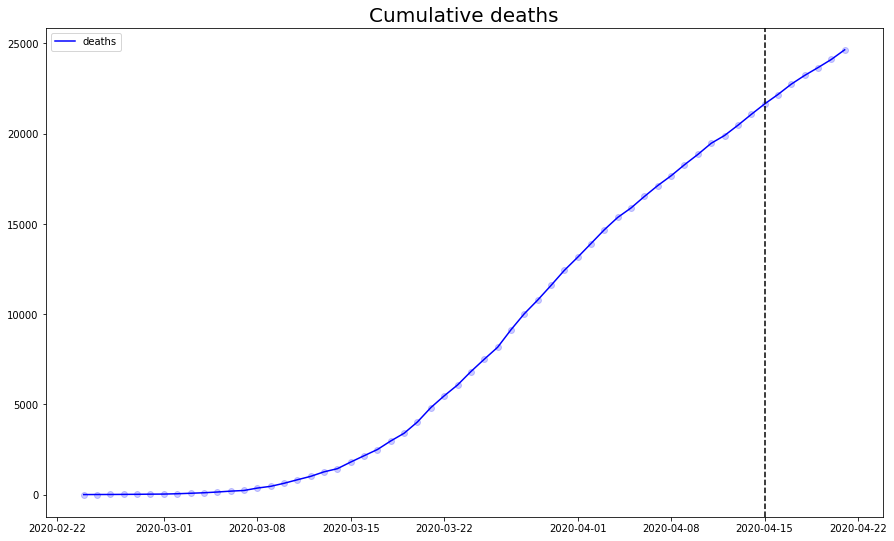

In [17]:
plot_function(gp = None, 
                data_plot = [data_1.index, data_1.deaths.values], 
                text_plot = ['Cumulative deaths', 'deaths'], prediction = False)

2. Build a suitable combination of kernels choosing from the ones shown in notebook_05.

In [18]:
def make_prediction(data_index, X_train, Y_train, gp_param, pred_label, detail = False):
    
    """
    This function make the prediction
    
    Parameters
    ----------
    data_index
        
    k         : gp object
        it is the kernel
    X_train   : array
        it is the X train set
    Y_train   : array
        it is the Y train set
    gp_param  : list
        it is a set of parameter for the prediction
    pred_label: string
        it is a string for the plot
    detail    : bool
        it is used to print more info about gp
        
    Returns
    -------
    None
    """
    
    # Create the regressor
    gp = GaussianProcessRegressor(kernel = gp_param[0], alpha = gp_param[1], 
                                  normalize_y = gp_param[2], n_restarts_optimizer = gp_param[3])
    gp.fit(X_train, Y_train) # learn the model

    if detail: # useful information
        print("kernel:", gp.kernel)
        print("kernel_:", gp.kernel_)
        print("kernel param:", gp.get_params())
        print("log marginal lik:", gp.log_marginal_likelihood_value_)
        print("theta param:", gp.kernel_.theta)
    
    # plot
    plot_function(gp = gp, 
                data_plot = [data_index, None], 
                text_plot = [str(gp.kernel_).replace(' +', '\n+'), pred_label], prediction = True)

In [19]:
# build kernels
k0 = 50 **2 * RBF(length_scale=50.0)

k1 = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-3, 1e9))  # noise terms
k2 = 20 * RBF(length_scale=100.0) * ExpSineSquared(length_scale=12.0, periodicity=1.0, periodicity_bounds="fixed") 

k3 = 20 * RBF(length_scale=100.0) * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")  # seasonal component
k4 = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-3, 1e9))  # noise terms

k5 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0) # medium term irregularities
k6 = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-3, 1e9))  # noise terms

k7 = 10 * DotProduct(sigma_0 = 4, )
k8 = 50**2 * RationalQuadratic(length_scale=50, alpha=0.5)

k9 = 50 * k1 + 20 * RBF(length_scale=100.0)
k10 = 50**2 * Matern(length_scale=50,nu=2.5)

k11 = k1 + (k2 + WhiteKernel(noise_level=0.1))
k12 = 50*k1 * (k2+ WhiteKernel(noise_level=0.1)) + ConstantKernel(constant_value=100) 

k13 = (70*k1 + 40 *k4) * (k2 + WhiteKernel(noise_level=0.1)) + ConstantKernel(constant_value=100) + (30**2 * DotProduct(sigma_0=1)) 
k14 = 100*(30**2 * DotProduct(sigma_0=1)) + 30* k3 # for linearity

k15 = 10 * 2 * RBF(length_scale = 1) + WhiteKernel(noise_level = 1e-05)
k16 = 34.4**2 * RBF(length_scale=41.8) \
+ 3.27**2 * RBF(length_scale=180) * ExpSineSquared(length_scale=1.44,
                                                   periodicity=1)\
+ 0.446**2 * RationalQuadratic(alpha=17.7, length_scale=0.957)\
+ 0.197**2 * RBF(length_scale=0.138) + WhiteKernel(noise_level=0.0336)
k17 = 10 * 2 * ExpSineSquared(length_scale=4, periodicity=1)

In [20]:
kernel1 = 10**2 * RBF(length_scale=20) # long term trend
kernel2 = 50 * DotProduct(sigma_0=0.5) # linear regression
kernel3 = 50**2 * Matern(length_scale=50,nu=2.5)
kernel4 = 20**2 * ExpSineSquared(length_scale=20)

kernel5 = 50*kernel2 * 20*kernel1 + WhiteKernel(noise_level=0.1)
kernel6 = kernel2 * kernel2 + WhiteKernel(noise_level=0.1)
kernel7 = 30*kernel2 + 70*kernel3
kernel8 = 100*(30**2 *kernel1) + 30* kernel3
kernel9 = (kernel2 * kernel2) * kernel3 * kernel4 + WhiteKernel(noise_level=0.1)

In [ ]:
# from here on out several attempts to set a suitable kernel...

<Figure size 720x504 with 0 Axes>

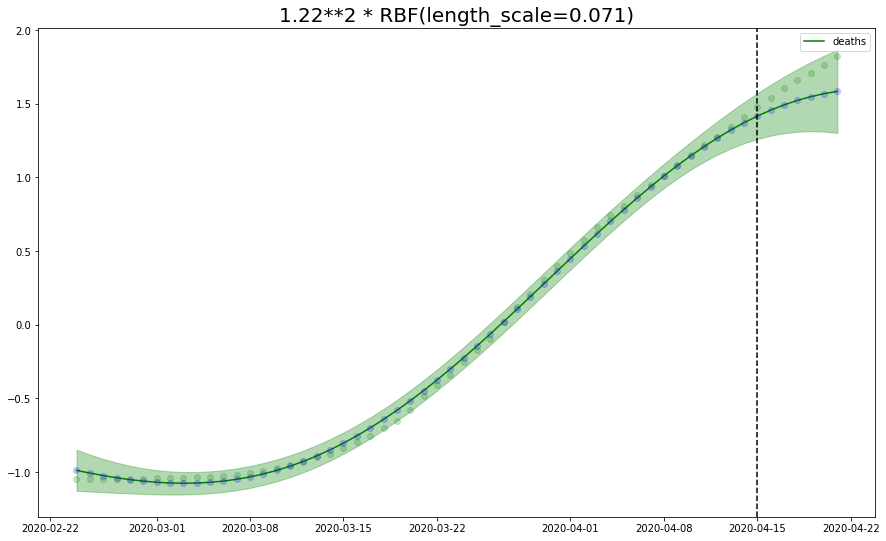

In [21]:
# set kernel
kernel = k0

# prediction
gp_param = [kernel, 0.1, True, 3]
make_prediction(data_1.index, X_train, Y_train, gp_param, 'deaths')

<Figure size 720x504 with 0 Axes>

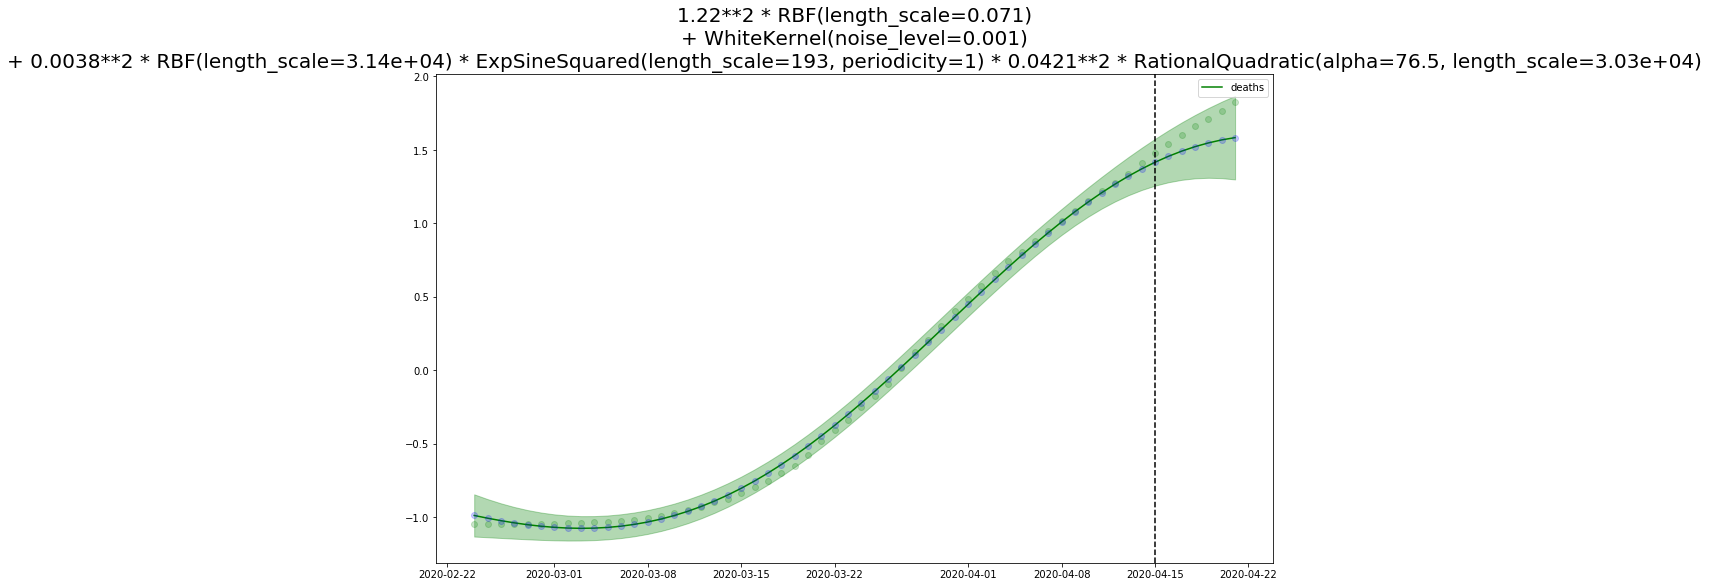

In [22]:
# set kernel
kernel = k1 + k2 * k5

# prediction
gp_param = [kernel, 0.1, True, 3]
make_prediction(data_1.index, X_train, Y_train, gp_param, 'deaths')

<Figure size 720x504 with 0 Axes>

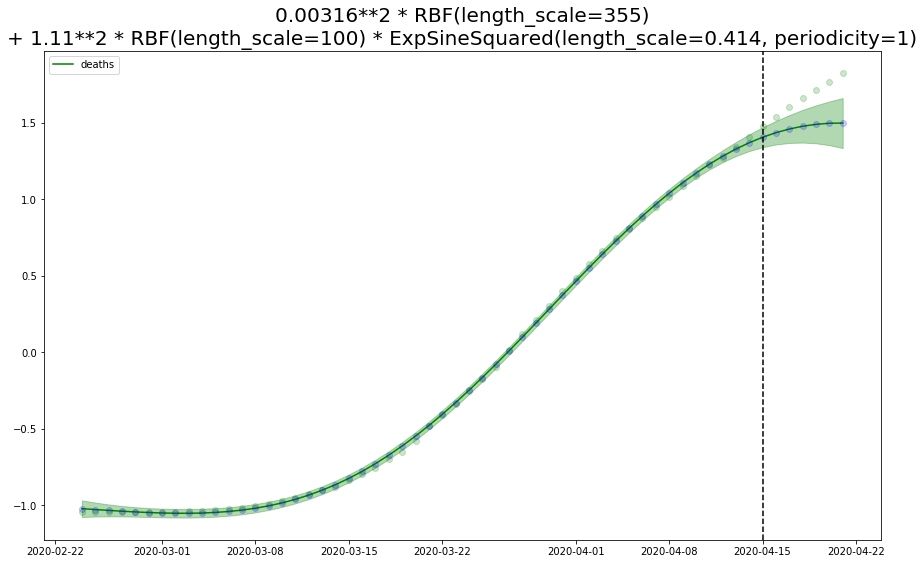

In [23]:
# set kernel
kernel = k0 + k2

# prediction
gp_param = [kernel, 0.01, True, 3]
make_prediction(data_1.index, X_train, Y_train, gp_param, 'deaths')

<Figure size 720x504 with 0 Axes>

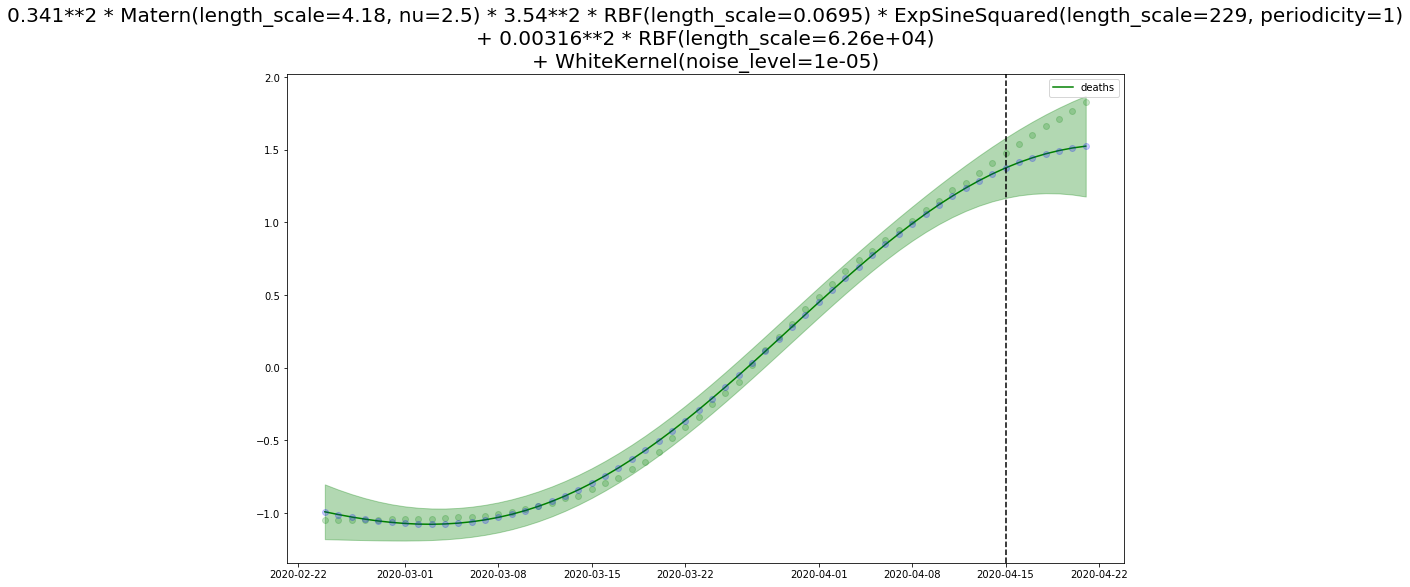

In [24]:
# set kernel
kernel = k10 * k2 + k15

# prediction
gp_param = [kernel, 0.21, True, 3]
make_prediction(data_1.index, X_train, Y_train, gp_param, 'deaths')

<Figure size 720x504 with 0 Axes>

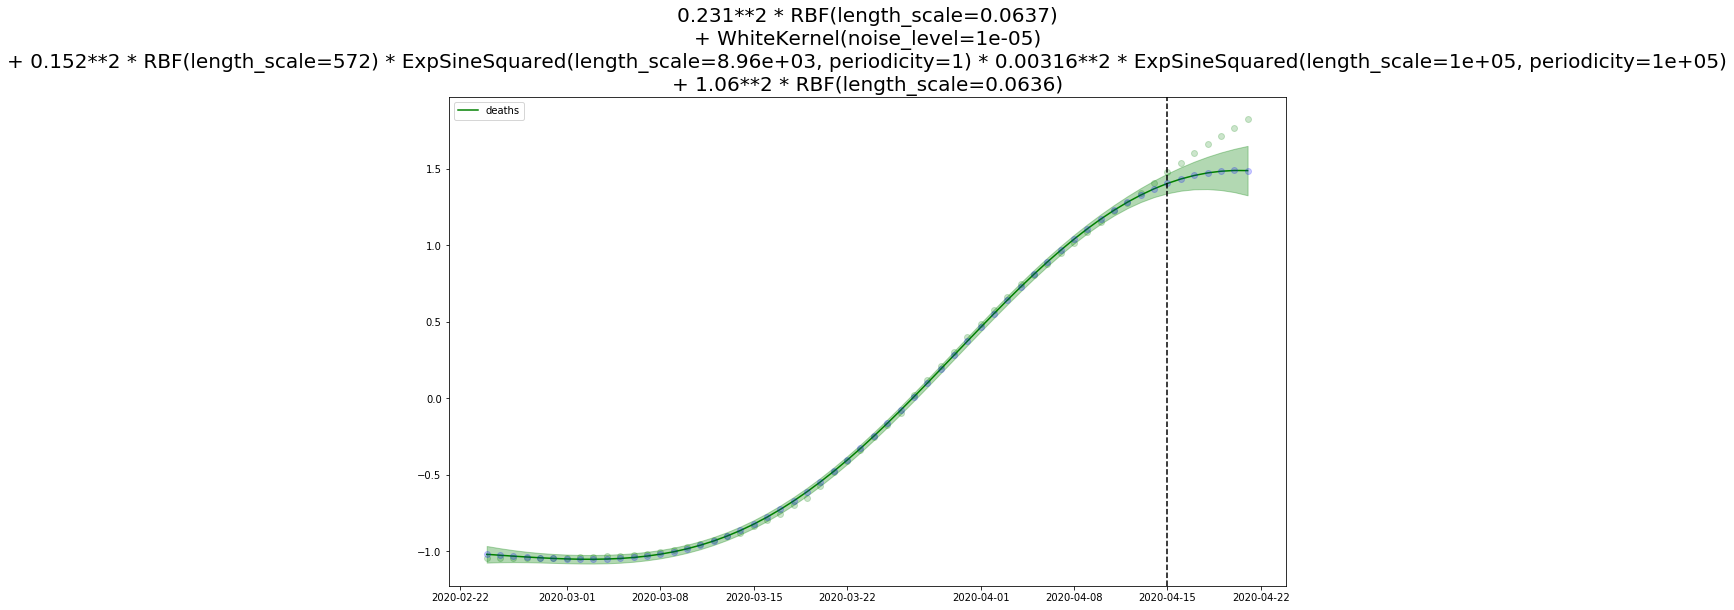

In [25]:
#set kernel
kernel = k15 + k2 * k17 + k0

# prediction
gp_param = [kernel, 0.01, True, 3]
make_prediction(data_1.index, X_train, Y_train, gp_param, 'deaths')

3. Fit a GaussianProcessRegressor to predict the daily number of swabs, plot future predictions and compare them to real test data.

In [61]:
# define new dataset to predict on the daily swabs
data_2 = copy.deepcopy(dataset) # work on a deep copied version of the original dataset
dates_to_idx(data = data_2, timelist = dataset.index, incorporate = True) # convert date to number
daily_swabs = dataset["swabs"].diff().fillna(dataset["swabs"][0]).values 
data_2["daily_swabs"] = daily_swabs # new column
data_2 = standardize_function(data_2, "daily_swabs") # standadized target

predict_size = 7 # leave last predict_size days as test set

input_data = ["t"]
output_data = ["y_n"]

# split dataset
X, Y, X_train, Y_train, X_test, Y_Test = split_function(data_2, input_data, output_data, predict_size)

# set the split date
datatime_split = pd.to_datetime(data_2.index.values[data_2.shape[0] - predict_size])

<Figure size 720x504 with 0 Axes>

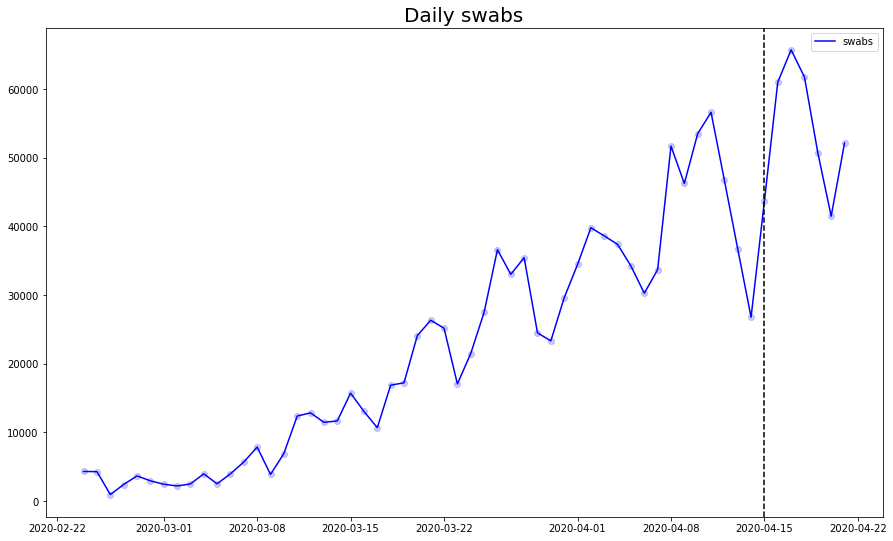

In [27]:
plot_function(gp = None, 
                data_plot = [data_2.index, data_2.daily_swabs.values], 
                text_plot = ['Daily swabs', 'swabs'], prediction = False)

<Figure size 720x504 with 0 Axes>

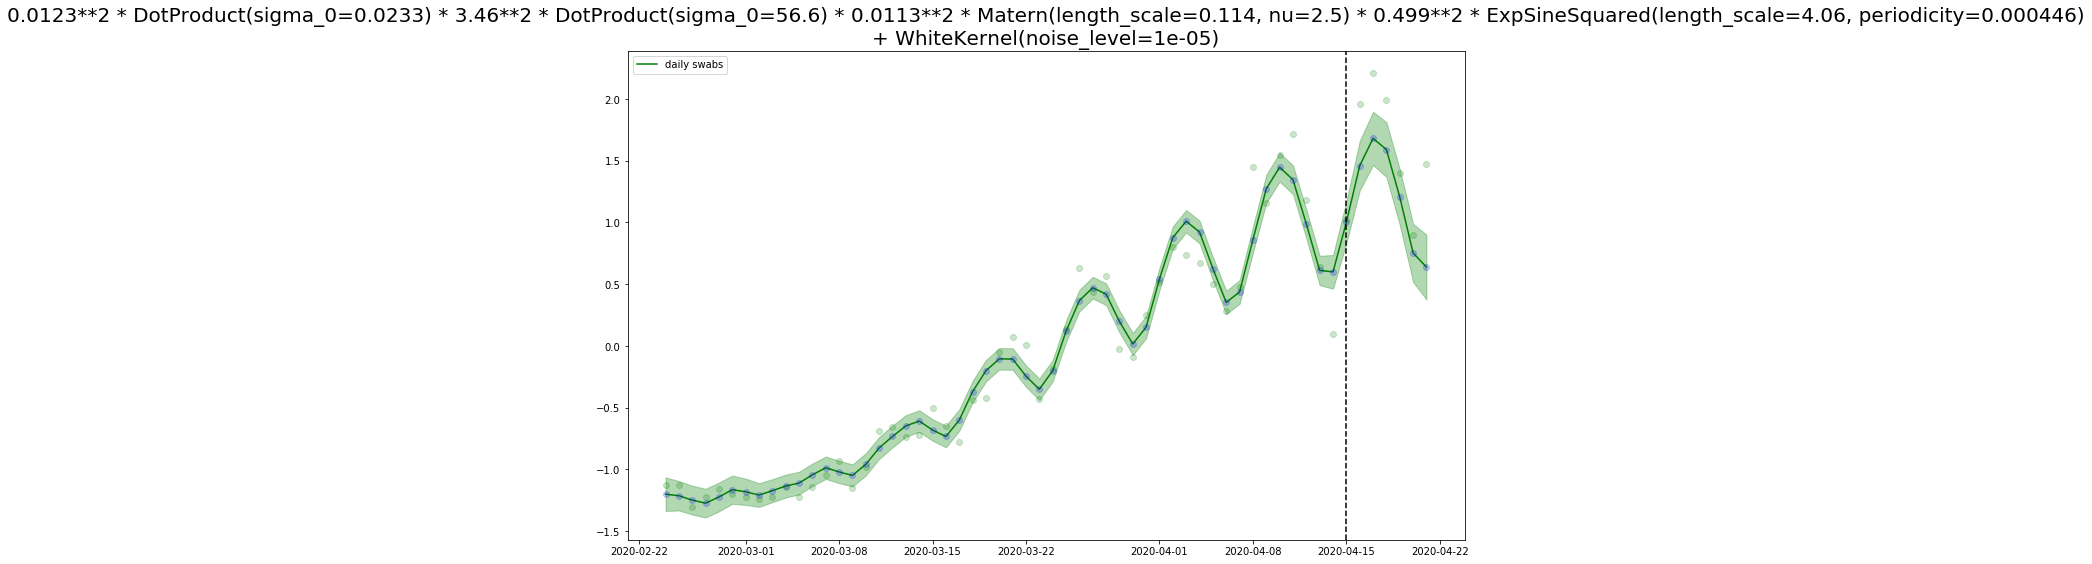

In [78]:
# set kernel
kernel = kernel9

# prediction
gp_param = [kernel, 0.05, True, 3]
make_prediction(data_2.index, X_train, Y_train, gp_param, 'daily swabs')

<Figure size 720x504 with 0 Axes>

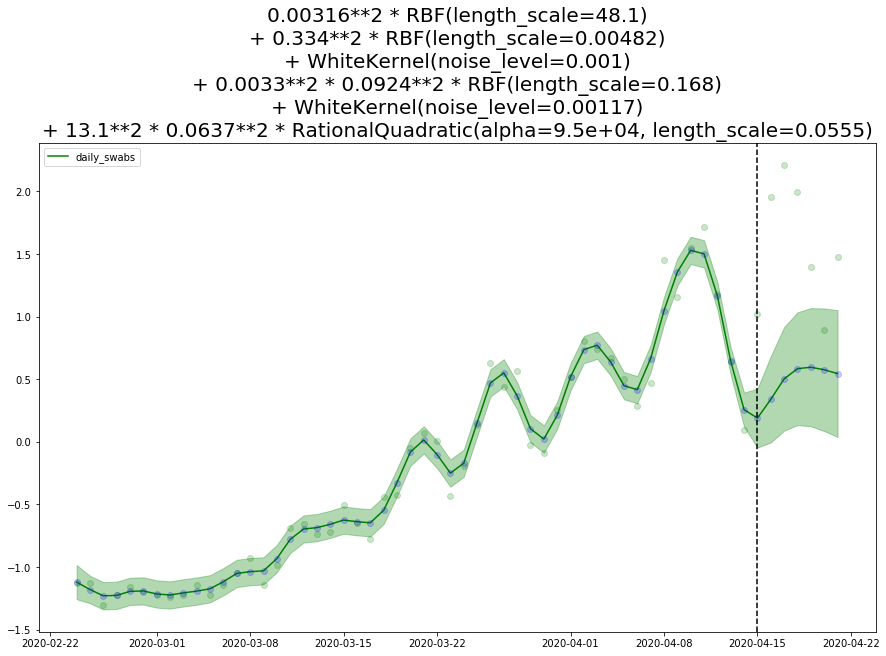

In [52]:
# set kernel
kernel = k0 + k4 + 10**2*k1 + 100**2*k5

# prediction
gp_param = [kernel, 0.025, True, 3]
make_prediction(data_2.index, X_train, Y_train, gp_param, 'daily_swabs')

4. Repeat points 1-3 on the daily number of swabs, which can be computed from the cumulative number provided in the dataset. You are welcome to try out and fit other data streams in the dataset.

In [53]:
# define new dataset to predict on the daily swabs
data_3 = copy.deepcopy(dataset) # work on a deep copied version of the original dataset
dates_to_idx(data = data_3, timelist = dataset.index, incorporate = True) # convert date to number
data_3 = standardize_function(data_3, "new_infections") # standardized target

predict_size = 7 # leave last predict_size days as test set

input_data = ["t"]
output_data = ["y_n"]

# split dataset
X, Y, X_train, Y_train, X_test, Y_Test = split_function(data_3, input_data, output_data, predict_size)

# set the split date
datatime_split = pd.to_datetime(data_3.index.values[data_3.shape[0] - predict_size])

<Figure size 720x504 with 0 Axes>

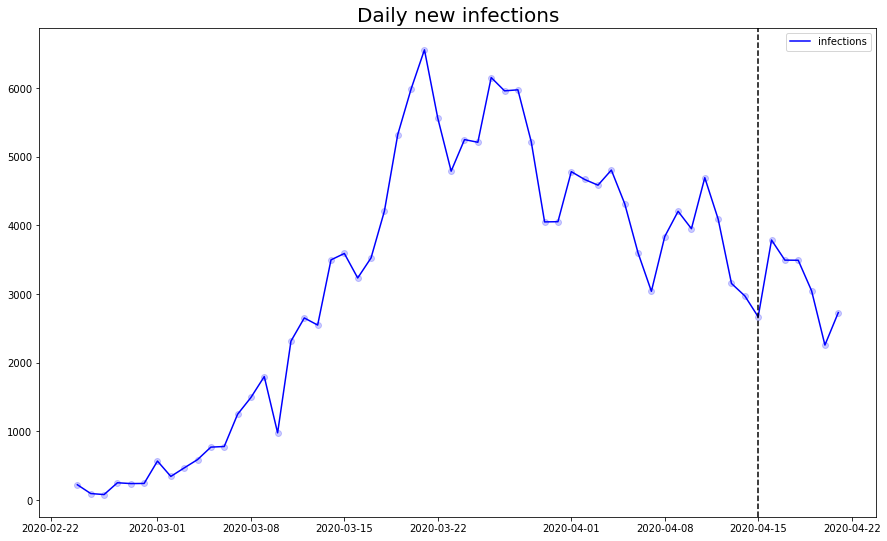

In [54]:
plot_function(gp = None, 
                data_plot = [data_3.index, data_3.new_infections.values], 
                text_plot = ['Daily new infections', 'infections'], prediction = False)

<Figure size 720x504 with 0 Axes>

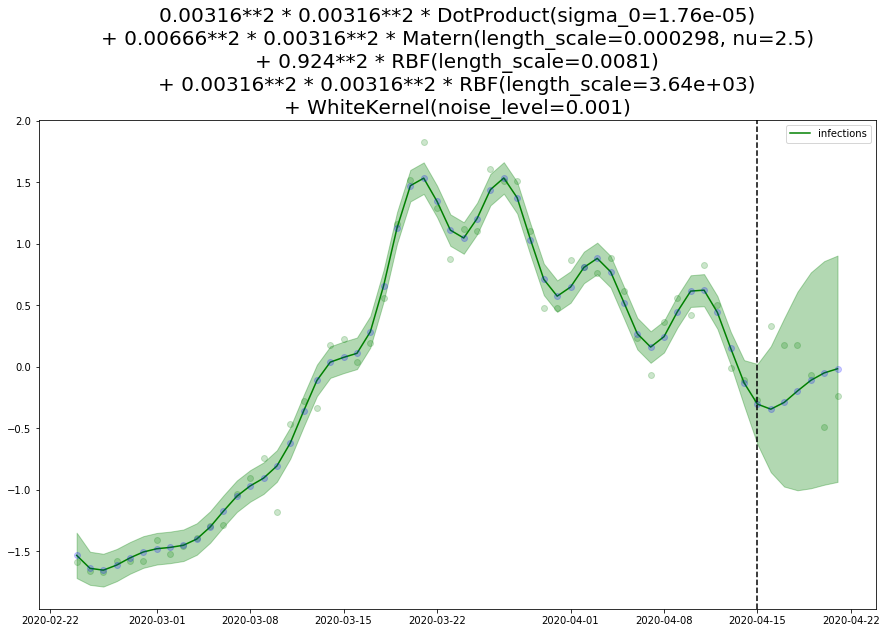

In [55]:
# set kernel
kernel = kernel7 + kernel1 + 0.05**2*k6

# prediction
gp_param = [kernel, 0.05, True, 3]
make_prediction(data_3.index, X_train, Y_train, gp_param, 'infections')

In [56]:
# note that...
max_infection = data_3["new_infections"].idxmax()
days_after_inf_peek = np.where(data_3.index == datatime_split)[0][0] - data_3["new_infections"].argmax()

In this prediction we used an RBF Kernel with a length scale of 50 and alpha equals to 0.4 that allows to enlarge the confidence interval (observation are quite distance among each other, so we have to consider a larger space). 

Moreover, the plot shows us an interesting point: the infections peak was already reached the {{ max_infection }}; so, the infections peak happened {{ days_after_inf_peek }} days before the prediction phase.

<Figure size 720x504 with 0 Axes>

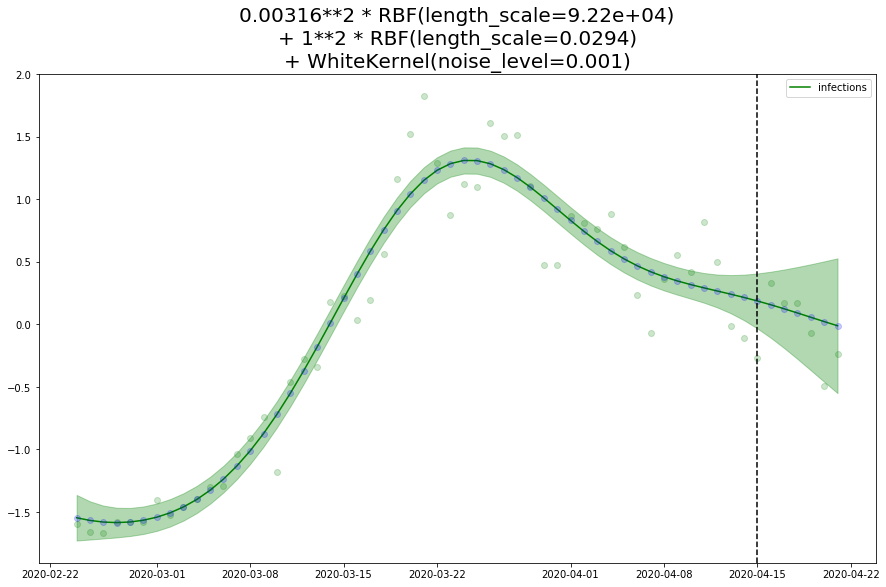

In [57]:
# set kernel
kernel = k0 + k1

# prediction
gp_param = [kernel, 0.1, True, 3]
make_prediction(data_3.index, X_train, Y_train, gp_param, 'infections')

In this other case we have an improvement on the predicted values even if we had reduce the confidence interval.

In [58]:
# define new dataset to predict on the daily swabs
data_4 = copy.deepcopy(dataset) # work on a deep copied version of the original dataset
dates_to_idx(data = data_4, timelist = dataset.index, incorporate = True) # convert date to number
data_4 = standardize_function(data_4, "hospitalized") # standardized target

predict_size = 7 # leave last predict_size days as test set

input_data = ["t"]
output_data = ["y_n"]

# split dataset
X, Y, X_train, Y_train, X_test, Y_Test = split_function(data_4, input_data, output_data, predict_size)

# set the split date
datatime_split = pd.to_datetime(data_4.index.values[data_3.shape[0] - predict_size])

<Figure size 720x504 with 0 Axes>

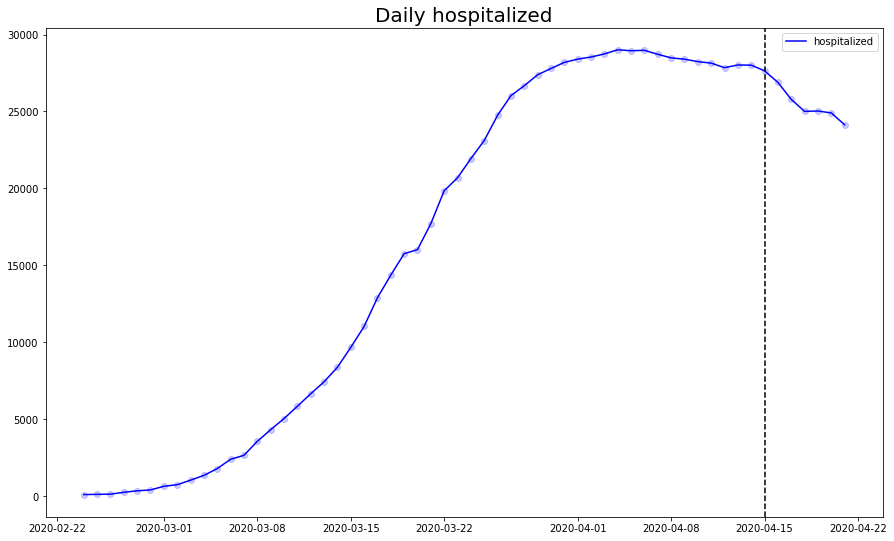

In [59]:
plot_function(gp = None, 
                data_plot = [data_3.index, data_3.hospitalized.values], 
                text_plot = ['Daily hospitalized', 'hospitalized'], prediction = False)

<Figure size 720x504 with 0 Axes>

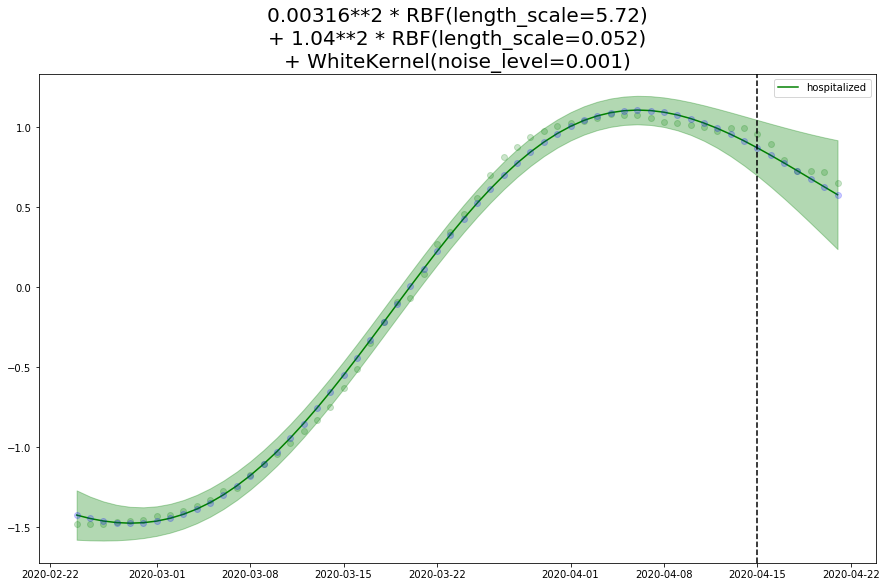

In [60]:
# set kernel
kernel = k0 + k1

# prediction
gp_param = [kernel, 0.1, True, 3]
make_prediction(data_4.index, X_train, Y_train, gp_param, 'hospitalized')